In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
from pylab import rcParams

from scipy.stats import spearmanr, chi2_contingency, pearsonr
import scipy.stats as stats

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.pipeline import Pipeline

In [43]:
path = 'BostonHousing.csv'

In [44]:
df = pd.read_csv(path)

### First look at dataset

In [45]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [46]:
df.describe().round(2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,0.01,0.00,0.46,0.00,0.38,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.22,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


In [ ]:
for i in df.columns:
    _ = plt.plot(range(len(df.crim)), np.sort(df[i]), marker='.', linestyle='None')
    _ = plt.xlabel(i)
    _ = plt.ylabel('Wartość')
    _ = plt.title(i)
    plt.show()

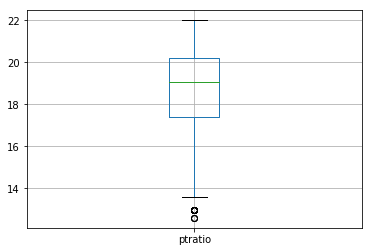

In [48]:
df.boxplot('ptratio')
plt.show()

#### Missing values

In [49]:
print("Missing Values: ")
df.apply(lambda x: sum(x.isnull()), axis=0)

Ilość brakujących wartości: 


crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

#### Preprocessing

In [50]:
categorical = [] #list of categorical features
for feature in df.columns:
    if len(np.unique(df[feature])) < 15:
        categorical.append(feature)

In [51]:
categorical_df = pd.DataFrame(df[categorical], columns = categorical)

In [53]:
columns = ['chas'+str(i) for i in np.unique(categorical_df.iloc[:, 0])]
chas_dummy = pd.get_dummies(categorical_df.iloc[:, 0])
chas_dummy.columns = columns

In [54]:
chas_dummy.head()

,chas0,chas1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [55]:
columns = ['rad'+str(i) for i in np.unique(categorical_df.iloc[:, 1])]
rad_dummy = pd.get_dummies(categorical_df.iloc[:, 1])
rad_dummy.columns = columns

In [56]:
rad_dummy.head()

,rad1,rad2,rad3,rad4,rad5,rad6,rad7,rad8,rad24
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0


In [57]:
numerical_df = pd.DataFrame(df[[f for f in df.columns if f not in categorical]]) #numerical features

In [58]:
numerical_df.head()

,crim,zn,indus,nox,rm,age,dis,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,222,18.7,396.90,5.33,36.2


In [59]:
#scaled categorical and numerical features
scaled = pd.DataFrame(scale(numerical_df, axis=1, with_mean = 0, with_std = 1), columns = numerical_df.columns)

C:\Users\onlyt\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [60]:
scaled.describe().round(2)

,crim,zn,indus,nox,rm,age,dis,tax,ptratio,b,lstat,medv
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,0.02,0.09,0.07,0.00,0.05,0.47,0.03,2.71,0.13,2.59,0.09,0.17
std,0.05,0.19,0.04,0.00,0.01,0.19,0.02,0.56,0.02,0.84,0.04,0.08
min,0.00,0.00,0.00,0.00,0.02,0.02,0.01,1.68,0.10,0.00,0.01,0.03
25%,0.00,0.00,0.04,0.00,0.04,0.34,0.01,2.27,0.11,1.98,0.05,0.11
50%,0.00,0.00,0.07,0.00,0.05,0.49,0.03,2.56,0.13,2.95,0.08,0.16
75%,0.02,0.10,0.09,0.00,0.05,0.62,0.04,3.32,0.15,3.18,0.11,0.20
max,0.45,0.84,0.25,0.01,0.07,0.96,0.11,3.72,0.21,3.51,0.28,0.44


In [61]:
y = ['medv']

In [62]:
df = pd.concat([scaled[[i for i in scaled.columns if i not in y]], chas_dummy, rad_dummy, scaled['medv']], axis = 1)

In [63]:
df.head().round(2)

,crim,zn,indus,nox,rm,age,dis,tax,ptratio,b,...,rad1,rad2,rad3,rad4,rad5,rad6,rad7,rad8,rad24,medv
0,0.0,0.14,0.02,0.0,0.05,0.51,0.03,2.34,0.12,3.13,...,1,0,0,0,0,0,0,0,0,0.19
1,0.0,0.00,0.06,0.0,0.05,0.66,0.04,2.02,0.15,3.32,...,0,1,0,0,0,0,0,0,0,0.18
2,0.0,0.00,0.06,0.0,0.06,0.52,0.04,2.04,0.15,3.31,...,0,1,0,0,0,0,0,0,0,0.29
3,0.0,0.00,0.02,0.0,0.06,0.39,0.05,1.90,0.16,3.38,...,0,0,1,0,0,0,0,0,0,0.29
4,0.0,0.00,0.02,0.0,0.06,0.46,0.05,1.89,0.16,3.39,...,0,0,1,0,0,0,0,0,0,0.31


In [64]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

#### PCA

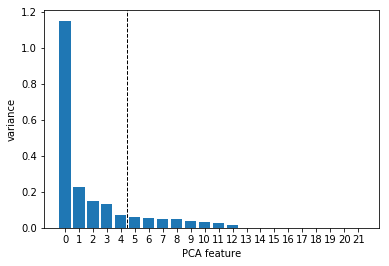

In [65]:
pca = PCA()
pca.fit(X)
features = range(pca.n_components_)
variances = pca.explained_variance_


%matplotlib inline
line =  np.sum(variances > 0.1) + 0.45
plt.bar(features, variances)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
_ = plt.axvline(line, color='k', linestyle='dashed', linewidth=1)
plt.show()

In [66]:
# pca = PCA(n_components=2)
# pca.fit(X)
# transformed = pca.transform(X)

#### Split data on train, validation and test set.

In [67]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                    test_size=0.2,
                                                    random_state=123)

In [68]:
xg_train = xgb.DMatrix(X_train, label = y_train)
xg_test = xgb.DMatrix(X_test, label = y_test)
xg_eval = xgb.DMatrix(X_val, label = y_val)

C:\Users\onlyt\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


#### xgboost regressor

In [69]:
param_test1 = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,6,2)
}

In [70]:
xg_reg = xgb.XGBRegressor(n_estimators=1000,
                         learning_rate=0.08,
                         gamma=0,
                         subsample=0.75,
                         colsample_bytree=1,
                         seed=123)

In [71]:
gsearch1 = RandomizedSearchCV(estimator=xg_reg,
                             param_distributions=param_test1,
                             cv=4,
                              verbose=1)

In [ ]:
gsearch1.fit(X_train, y_train)

In [73]:
gsearch1.best_params_

{'min_child_weight': 3, 'max_depth': 3}

In [74]:
gsearch1.best_score_

0.9156371160013344

In [75]:
xg_reg = gsearch1.best_estimator_

In [76]:
xgb_param = xg_reg.get_xgb_params()

#### Cross Walidation

In [77]:
cv_res = xgb.cv(xgb_param,
               xg_train,
               num_boost_round=5000,
               nfold=5,
               early_stopping_rounds=50,
               seed=1301)

In [78]:
xg_reg.set_params(n_estimators=cv_res.shape[0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=491, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=123, silent=True,
       subsample=0.75)

#### Model learning on optimal parameters after cross validation

In [79]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=491, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=123, silent=True,
       subsample=0.75)

#### Prediction

In [80]:
preds = xg_reg.predict(X_test)

In [81]:
"Accuracy: " + str(np.round(explained_variance_score(preds, y_test),3))

'Accuracy: 0.888'

In [82]:
from sklearn.metrics import accuracy_score, mean_squared_error

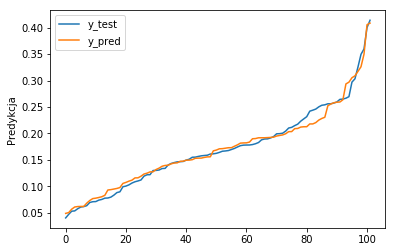

In [83]:
plt.plot(range(y_test.shape[0]), np.sort(np.array(y_test)))
plt.plot(range(preds.shape[0]), np.sort(preds))
plt.legend(['y_test', 'y_pred'])
plt.ylabel('Prediction')
plt.show()

### Conjoint analysis

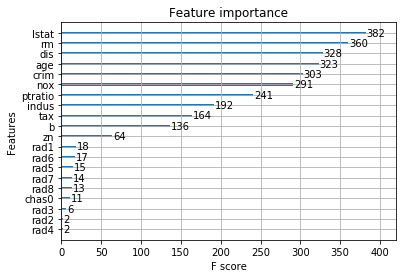

In [85]:
xgb.plot_importance(xg_reg)